# Opening a Café in Toronto

**Objectives:**

1. Scrapping Toronto neighborhood data from Wikipedia.
2. Loading and merging coordinate data for neighborhoods.
3. Using Foursquare API to get recommended food venues for all neighborhoods.
4. Cluster Neighborhoods using venues data.
5. Select appropriate neighborhood for new Café.

## Scrapping Toronto Neighborhood Data from Wikipedia

In [1]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
import folium
from geopy.geocoders import Nominatim 
import requests
from bs4 import BeautifulSoup
import config

**Specifying the url and creating BeautifulSoup Object for parsing**

In [2]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = requests.get(wiki_url).text
soup = BeautifulSoup(html, 'html5lib')

**Parsing and Loading data in a List**

In [3]:
table_contents = []
table = soup.find('table')
for row in table.findAll('td'):
    cell={}
    if row.span.text == 'Not assigned': 
        pass                                   # Passing over cells with only Postal Code and no other details
    else:
        cell['PostalCode'] = row.p.text[:3]    # Three Digit Postal Code
        cell['Borough'] = (row.span.text).split('(')[0] # borough name is first element in span tag
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace('/',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

The Neighborhood column members required a lot of cleaning. This was done at the time of loading the data itself.

**Converting the Table into a Pandas Dataframe**

In [4]:
df = pd.DataFrame(table_contents)
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South , King's Mill Park , Sunnylea ,..."


The Borough column has a lot of unnecessary text. Lets clean it up!

In [5]:
df['Borough'] = df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                        'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                        'EtobicokeNorthwest':'Etobicoke Northwest',
                                        'East YorkEast Toronto':'East York/East Toronto',
                                        'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [6]:
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern , Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill , Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


**Printing Results of Scrapping and Cleaning.**

In [7]:
print(f'My dataframe has {df.shape[0]} rows and {df.shape[1]} columns')

My dataframe has 103 rows and 3 columns


## Getting Latitude and Longitude for Toronto Neighborhood Data

This step can be completed using geocoder library or using the provided csv. I chose the later as geocoder was taking a long time. 

**Importing Latitude Longitude data and merging dataframes**

In [8]:
lat_lng_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'
lat_lng_df = pd.read_csv(lat_lng_url)
lat_lng_df 

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [9]:
lat_lng_df.rename(columns = {'Postal Code':'PostalCode'}, inplace=True) 

In [10]:
tor_df = pd.merge(df,lat_lng_df,on='PostalCode') # Final Data 
tor_df.to_csv('toronto_neigh.csv', index=False)
tor_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South , King's Mill Park , Sunnylea ,...",43.636258,-79.498509


## Scrapping Mumbai Neighborhood Data from Wikipedia

In [11]:
mum_url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
mum_df = pd.read_html(mum_url)[0]
mum_df.rename(columns = {'Area':'Neighborhood','Location':'District'}, inplace=True)
mum_df.to_csv('mumbai_neigh.csv', index=False)
mum_df

,Neighborhood,District,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,Chakala,"Andheri,Western Suburbs",19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
...,...,...,...,...
88,Parel,South Mumbai,18.990000,72.840000
89,Gowalia Tank,"Tardeo,South Mumbai",18.962450,72.809703
90,Dava Bazaar,South Mumbai,18.946882,72.831362
91,Dharavi,Mumbai,19.040208,72.850850


## Visaulizing Neighborhoods

We will use Folium library to vizualize the neighborhood data.


### Toranto Neighborhoods Distribution

In [12]:
tor_neigh_map = folium.Map(location = [43.6532,-79.3832], zoom_start=10)

for lat, lng, neighborhood, borough in zip(tor_df['Latitude'], tor_df['Longitude'], tor_df['Neighborhood'], tor_df['Borough']):
    label = f'{neighborhood},{borough}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    color='blue',
    popup = label,
    fill = True,
    fill_color='blue',
    fill_opacity=0.5,
    parse_html=False).add_to(tor_neigh_map)
    
tor_neigh_map

### Mumbai Neighborhood Distribution

In [13]:
mum_neigh_map = folium.Map(location = [19.0760, 72.8777], zoom_start=10)

for lat, lng, neighborhood, district in zip(mum_df['Latitude'], mum_df['Longitude'], mum_df['Neighborhood'], mum_df['District']):
    label = f'{neighborhood},{district}'
    label = folium.Popup(label)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    color='red',
    popup = label,
    fill = True,
    fill_color='red',
    fill_opacity=0.5
    ).add_to(mum_neigh_map)
    
mum_neigh_map

Doing a few prelimnary operations on the dataframes before joining.

In [14]:
mum_df['City'] = 'Mumbai'
tor_df['City'] = 'Toronto'
tor_df.drop('PostalCode', axis=1, inplace=True)

Joining the two dataframes to produce the final **neigh_df**.

In [15]:
neigh_df = pd.DataFrame(columns=['Neighborhood','City','Latitude','Longitude'])
neigh_df = neigh_df.append(tor_df.loc[:,['Neighborhood','City','Latitude','Longitude']])
neigh_df = neigh_df.append(mum_df.loc[:,['Neighborhood','City','Latitude','Longitude']], ignore_index=True)
neigh_df

,Neighborhood,City,Latitude,Longitude
0,Parkwoods,Toronto,43.753259,-79.329656
1,Victoria Village,Toronto,43.725882,-79.315572
2,"Regent Park , Harbourfront",Toronto,43.654260,-79.360636
3,"Lawrence Manor , Lawrence Heights",Toronto,43.718518,-79.464763
4,Ontario Provincial Government,Toronto,43.662301,-79.389494
...,...,...,...,...
191,Parel,Mumbai,18.990000,72.840000
192,Gowalia Tank,Mumbai,18.962450,72.809703
193,Dava Bazaar,Mumbai,18.946882,72.831362
194,Dharavi,Mumbai,19.040208,72.850850


Requesting category Id data from foursquare api

In [16]:
cat_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
    config.CLIENT_ID,config.CLIENT_SECRET,config.VERSION
)
categories = requests.get(cat_url).json()['response']['categories']

cat_dict={}
for cat in categories:
    for a in cat['categories']:
        cat_dict[a['name']] = []
        cat_dict[a['name']].append(a['id'])
        if a['categories']:
            for b in a['categories']:
                cat_dict[a['name']].append(b['id'])
                if b['categories']:
                    for c in b['categories']:
                        cat_dict[a['name']].append(c['id'])
                    
categories

[{'id': '4d4b7104d754a06370d81259',
  'name': 'Arts & Entertainment',
  'pluralName': 'Arts & Entertainment',
  'shortName': 'Arts & Entertainment',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
   'suffix': '.png'},
  'categories': [{'id': '56aa371be4b08b9a8d5734db',
    'name': 'Amphitheater',
    'pluralName': 'Amphitheaters',
    'shortName': 'Amphitheater',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
     'suffix': '.png'},
    'categories': []},
   {'id': '4fceea171983d5d06c3e9823',
    'name': 'Aquarium',
    'pluralName': 'Aquariums',
    'shortName': 'Aquarium',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
     'suffix': '.png'},
    'categories': []},
   {'id': '4bf58dd8d48988d1e1931735',
    'name': 'Arcade',
    'pluralName': 'Arcades',
    'shortName': 'Arcade',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_ent

### Some Useful Functions

In [17]:
def get_header_cat(cat_id):
    """Funtion for converting sub categories back to main categories"""
    cat_keys=list(cat_dict.keys())
    cat_values=list(cat_dict.values())
    for id_list in cat_values:
        if cat_id in id_list:
            return cat_keys[cat_values.index(id_list)]

In [18]:
def get_venues(df, radius=1500, limit=100):
    '''Function to return a DataFrame of venues given neighborhood name and location in pd.DataFrame, 
    radius of search and max venues for each neighbourhood'''
    
    venues = []

    for city, neigh, lat, lng in zip(df.City, df.Neighborhood, df.Latitude, df.Longitude):
        fsq_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius{}&limit{}'.format(
        config.CLIENT_ID, config.CLIENT_SECRET, lat, lng, config.VERSION, radius, limit)
        response = requests.get(fsq_url).json()['response']
        if response:
            res = response['groups'][0]['items']
            venues.append([[
                city,
                neigh, 
                venue['venue']['name'],
                venue['venue']['id'],
                venue['venue']['categories'][0]['name'],
                venue['venue']['categories'][0]['id'],
                venue['venue']['location']['lat'],
                venue['venue']['location']['lng']
            ] for venue in res])
        else:
            print(f'No response for {neigh} Neighborhood')
            
    ven_df = pd.DataFrame([item for venue in venues for item in venue])
    ven_df.columns = ['City','Neighborhood','Name','id','Category','Category_id','Latitude','Longitude']
    return(ven_df)

Using `get_venues()` function to procure top 30(foursquare limit) recommended venues for neighborhoods in datafrme neigh_df. This is followed by creating a separate header category column to group similar sub categories together.

In [19]:
venues_df = get_venues(neigh_df)
venues_df['Category_head'] = venues_df['Category_id'].apply(get_header_cat)
venues_df

,City,Neighborhood,Name,id,Category,Category_id,Latitude,Longitude,Category_head
0,Toronto,Parkwoods,Allwyn's Bakery,4b8991cbf964a520814232e3,Caribbean Restaurant,4bf58dd8d48988d144941735,43.759840,-79.324719,Caribbean Restaurant
1,Toronto,Parkwoods,Donalda Golf & Country Club,4bd4846a6798ef3bd0c5618d,Golf Course,4bf58dd8d48988d1e6941735,43.752816,-79.342741,Athletics & Sports
2,Toronto,Parkwoods,Graydon Hall Manor,4b8ec91af964a520053733e3,Event Space,4bf58dd8d48988d171941735,43.763923,-79.342961,Event Space
3,Toronto,Parkwoods,Island Foods,4b0aed06f964a520202a23e3,Caribbean Restaurant,4bf58dd8d48988d144941735,43.745866,-79.346035,Caribbean Restaurant
4,Toronto,Parkwoods,Tim Hortons,57e286f2498e43d84d92d34a,Café,4bf58dd8d48988d16d941735,43.760668,-79.326368,Café
...,...,...,...,...,...,...,...,...,...
5846,Mumbai,Thane,INOX,4bee5bf02c082d7f2e5c3042,Multiplex,4bf58dd8d48988d180941735,19.202484,72.965709,Movie Theater
5847,Mumbai,Thane,Pizza Express,529a039c498e0ada6f188287,Pizza Place,4bf58dd8d48988d1ca941735,19.208268,72.971980,Pizza Place
5848,Mumbai,Thane,Sheetal Grille,4e7df5aa775b53d25b7c2cfd,Indian Restaurant,4bf58dd8d48988d10f941735,19.207297,72.977414,Indian Restaurant
5849,Mumbai,Thane,Forever 21,51cc7f3250194122e65077f5,Clothing Store,4bf58dd8d48988d103951735,19.208282,72.972044,Clothing Store


In [20]:
venues_df['Category_head'].value_counts()

Indian Restaurant         496
Asian Restaurant          454
Dessert Shop              296
Café                      257
Coffee Shop               254
                         ... 
Aquarium                    1
Ski Area                    1
Lake                        1
Gluten-free Restaurant      1
Bridge                      1
Name: Category_head, Length: 187, dtype: int64

Getting a list containing venue categories with less than 50 entries in the venues_df. There are 162 such categories.

In [21]:
a = venues_df['Category_head'].value_counts() >= 50
not_pop_venues = [x for x in a.index if a.loc[x] == False]
len(not_pop_venues)

162

Converting **Category_head** categorical column into usable features using **one-hot encoding**. This is followed by adding proper rows and grouping data for different purposes.

In [22]:
one_hot = pd.get_dummies(venues_df['Category_head'])

one_hot['Neighborhood'] = venues_df['Neighborhood']
one_hot['City'] = venues_df['City']

df1 = one_hot.groupby(by='Neighborhood').sum()
df1.drop(not_pop_venues, axis=1, inplace=True)

df2 = one_hot.groupby(by='City').sum()
df2.drop(not_pop_venues, axis=1, inplace=True)

#### Dataframe showing venue distribution against neighborhood name

In [23]:
df1

,Asian Restaurant,Athletics & Sports,Bakery,Bar,Brewery,Café,Clothing Store,Coffee Shop,Dessert Shop,Fast Food Restaurant,...,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Park,Pizza Place,Restaurant,Sandwich Place,Seafood Restaurant,Vegetarian / Vegan Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Aarey Milk Colony,4,1,0,2,0,0,0,0,2,1,...,1,0,0,0,0,1,3,0,0,0
Agincourt,10,2,2,0,0,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
Agripada,2,1,1,1,0,1,0,0,4,2,...,0,0,1,1,0,0,2,0,0,0
"Alderwood , Long Branch",0,2,1,0,0,2,0,2,0,1,...,0,1,0,0,2,2,1,1,1,0
Altamount Road,1,2,3,0,1,0,1,1,0,2,...,0,0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woburn,2,4,0,2,0,0,0,2,0,0,...,0,0,0,0,3,0,1,0,0,0
Woodbine Heights,1,1,1,2,0,2,0,3,2,0,...,0,0,1,0,2,0,0,1,0,0
Worli,2,1,0,3,0,0,0,0,1,0,...,1,0,0,1,0,1,1,0,2,0


#### Dataframe showing venue distribution against city name

In [24]:
df2

,Asian Restaurant,Athletics & Sports,Bakery,Bar,Brewery,Café,Clothing Store,Coffee Shop,Dessert Shop,Fast Food Restaurant,...,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Park,Pizza Place,Restaurant,Sandwich Place,Seafood Restaurant,Vegetarian / Vegan Restaurant
City,,,,,,,,,,,,,,,,,,,,,
Mumbai,117.0,74.0,79.0,134.0,20.0,121.0,34.0,74.0,212.0,107.0,...,61.0,6.0,14.0,44.0,13.0,70.0,111.0,39.0,51.0,27.0
Toronto,337.0,133.0,112.0,95.0,40.0,136.0,36.0,180.0,84.0,8.0,...,2.0,53.0,67.0,18.0,130.0,44.0,75.0,29.0,28.0,23.0


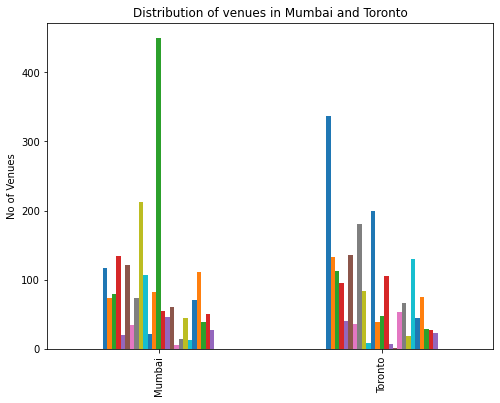

In [25]:
df2.plot(kind='bar', legend=False, figsize=(8,6), ylabel='No of Venues', xlabel='')
plt.title('Distribution of venues in Mumbai and Toronto')
plt.savefig('venue_dist')

#### The relative shapes of the distributions indicate significant difference in distribution of venues in the two cities.

### Clustering Neighborhoods

In [26]:
X = df1.values
X

array([[ 4,  1,  0, ...,  0,  0,  0],
       [10,  2,  2, ...,  0,  0,  0],
       [ 2,  1,  1, ...,  0,  0,  0],
       ...,
       [ 2,  1,  0, ...,  0,  2,  0],
       [ 2,  0,  0, ...,  0,  1,  0],
       [ 5,  1,  3, ...,  1,  1,  0]], dtype=uint8)

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled

array([[ 0.7279892 , -0.05523038, -0.90179656, ..., -0.64671048,
        -0.59101877, -0.49890362],
       [ 3.32227797,  0.92887452,  0.94901104, ..., -0.64671048,
        -0.59101877, -0.49890362],
       [-0.13677373, -0.05523038,  0.02360724, ..., -0.64671048,
        -0.59101877, -0.49890362],
       ...,
       [-0.13677373, -0.05523038, -0.90179656, ..., -0.64671048,
         2.34163132, -0.49890362],
       [-0.13677373, -1.03933527, -0.90179656, ..., -0.64671048,
         0.87530628, -0.49890362],
       [ 1.16037066, -0.05523038,  1.87441483, ...,  1.21733737,
         0.87530628, -0.49890362]])

In [28]:
X_scaled.shape

(196, 25)

(0.0, 51.0, 0.1, 0.2)

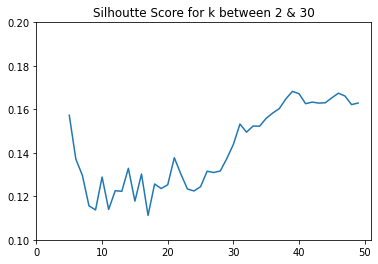

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
score={}
for k in range(5,50):
    kmeans = KMeans(n_clusters=k, random_state=1)
    pred = kmeans.fit_predict(X)
    score[k] = silhouette_score(X, kmeans.labels_)
    
sns.lineplot(x =list(score.keys()), y=list(score.values()))
plt.title('Silhoutte Score for k between 2 & 30')
plt.axis([0,51,0.1,0.2])

K = 38 gives the highest Silhoutte Score among the values tested.

In [30]:
score[38]

0.1648365795817885

In [31]:
kmeans = KMeans(n_clusters=38, random_state=1)
pred = kmeans.fit_predict(X)
pred

array([33, 18, 16, 14, 11, 13, 30, 30,  5, 27, 30, 31,  6, 27,  2,  1, 37,
        5, 23, 11, 27, 21, 17, 20, 11, 16,  3, 35, 33,  1, 36,  4, 16,  5,
       22, 22,  7,  0,  8, 23, 27,  1,  7, 11, 33, 24,  5,  9,  5, 20, 20,
       20,  4, 21, 16, 11, 10, 14, 12,  8, 31, 26,  3, 31, 25, 31, 28, 27,
       10, 31, 16, 27, 20, 24,  3, 26, 10, 12, 16, 17, 14, 27, 18, 14,  1,
        3,  8, 20,  9, 28,  1,  9, 15,  4, 29, 27, 22,  1, 16, 23,  2, 22,
       16,  0, 26, 20,  2, 22, 13, 33, 11, 37,  4, 21, 12, 14,  1, 16, 16,
        4,  5, 18, 31,  4, 17, 16, 30, 34, 34,  7,  7,  4, 23, 31, 20, 35,
       14, 35, 16, 16, 12, 33, 14, 10, 10, 36,  1, 35, 27, 17, 20, 17, 20,
       15, 19, 23, 24, 21,  8, 27, 23, 18,  3, 20, 30, 37, 30, 14, 14, 14,
       15, 15,  2, 27, 27, 10, 12, 24, 32, 30,  1, 29, 37, 12,  2,  8,  8,
       32,  6,  6,  6, 23,  2, 33, 10,  8])

Adding the Cluster Column into venue dataframe, followed by adding city column

In [32]:
df1.insert(0, 'Cluster', pred, True)
df1.reset_index(inplace=True)

In [33]:
sorted_df = neigh_df.loc[:,['Neighborhood','City']].sort_values(by='Neighborhood')
df1['City'] = sorted_df['City']
df1

,Neighborhood,Cluster,Asian Restaurant,Athletics & Sports,Bakery,Bar,Brewery,Café,Clothing Store,Coffee Shop,...,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Park,Pizza Place,Restaurant,Sandwich Place,Seafood Restaurant,Vegetarian / Vegan Restaurant,City
0,Aarey Milk Colony,33,4,1,0,2,0,0,0,0,...,0,0,0,0,1,3,0,0,0,Toronto
1,Agincourt,18,10,2,2,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,Toronto
2,Agripada,16,2,1,1,1,0,1,0,0,...,0,1,1,0,0,2,0,0,0,Toronto
3,"Alderwood , Long Branch",14,0,2,1,0,0,2,0,2,...,1,0,0,2,2,1,1,1,0,Toronto
4,Altamount Road,11,1,2,3,0,1,0,1,1,...,0,0,0,0,1,1,1,0,0,Toronto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Woburn,23,2,4,0,2,0,0,0,2,...,0,0,0,3,0,1,0,0,0,Mumbai
192,Woodbine Heights,2,1,1,1,2,0,2,0,3,...,0,1,0,2,0,0,1,0,0,Mumbai
193,Worli,33,2,1,0,3,0,0,0,0,...,0,0,1,0,1,1,0,2,0,Mumbai
194,"York Mills , Silver Hills",10,2,0,0,1,0,0,0,0,...,0,2,0,1,0,1,0,1,0,Mumbai


In [34]:
lis = list(df1[['Neighborhood','Cluster']].groupby(by='Cluster').count().sort_values(by='Neighborhood', ascending=False).head(10).index)
lis # List of 10 largest clusters.

[16, 27, 20, 14, 1, 10, 30, 23, 31, 4]

In [35]:
count_df = df1[['Neighborhood','Cluster','City']].groupby(by=['Cluster','City']).count()
count_df.head()

Neighborhood
Cluster City                 
0       Mumbai              1
        Toronto             1
1       Mumbai              3
        Toronto             6
2       Mumbai              4

In [36]:
cluster_size = {}
for (i,j) in count_df.index:
    if i in cluster_size.keys():
        cluster_size[i] += count_df.loc[(i,j),'Neighborhood']
    else:
        cluster_size[i] = count_df.loc[(i,j),'Neighborhood']

for (i,j) in count_df.index:
    count_df.loc[(i,j),'neigh_ratio'] = count_df.loc[(i,j),'Neighborhood'] / cluster_size[i]

for i in lis:
    print(f'-----------------Cluster No. {i}-----------------')
    print(count_df.loc[(i)])
    print('\n')

-----------------Cluster No. 16-----------------
         Neighborhood  neigh_ratio
City                              
Mumbai              5     0.384615
Toronto             8     0.615385


-----------------Cluster No. 27-----------------
         Neighborhood  neigh_ratio
City                              
Mumbai              4     0.333333
Toronto             8     0.666667


-----------------Cluster No. 20-----------------
         Neighborhood  neigh_ratio
City                              
Mumbai              5     0.454545
Toronto             6     0.545455


-----------------Cluster No. 14-----------------
         Neighborhood  neigh_ratio
City                              
Mumbai              6          0.6
Toronto             4          0.4


-----------------Cluster No. 1-----------------
         Neighborhood  neigh_ratio
City                              
Mumbai              3     0.333333
Toronto             6     0.666667


-----------------Cluster No. 10---------------

Let us look at one of the clusters to see the distribution of features within the cluster.

In [37]:
def show_cluster(df, i):
    a = df[df['Cluster'] == i].copy()
    for col in a.columns:
        if col in ['Neighborhood','City','Cluster']:
            pass
        else:
            if a.loc[:,col].max() == 0:
                a.drop(col, axis=1, inplace=True)
    print(f'--------------------------Cluster No. {i}--------------------------')
    print(a)
    print('\n')
            

In [39]:
show_cluster(df1, 14)

--------------------------Cluster No. 14--------------------------
                                          Neighborhood  Cluster  \
3                              Alderwood , Long Branch       14   
57                                     Don Mills South       14   
80   Harbourfront East , Union Station , Toronto Is...       14   
83                                        Hindu colony       14   
115                                    Malvern , Rouge       14   
136  Old Mill South , King's Mill Park , Sunnylea ,...       14   
142                            Parkdale , Roncesvalles       14   
167              The Annex , North Midtown , Yorkville       14   
168                                        The Beaches       14   
169                                 The Danforth  East       14   

     Asian Restaurant  Athletics & Sports  Bakery  Bar  Brewery  Café  \
3                   0                   2       1    0        0     2   
57                  2                   1       0

## Conclusion

- Mumbai and Toronto show very different distributions for venues.
- The total 196 neighborhoods were clustered into 38 clusters.
- Against the previous notion, majority of largest clusters were composed of almost equal number of neighborhoods from both cities.
- The clusters take into account most of the features.
- The final conclusion of the project is that there is high degree of difference between neighborhoods within a city but, there are similarities among various neighborhoods irrespective of their location.